# Sequence-to-sequence with attention

This notebook showcase traditional attention models, namely Bahdanau (additive) and Luong (multiplicative) attentions. The goal is to transliterate text to pronunciation (i.e. grapheme-to-phoneme task).

Possible variants are:

 * Use explicit `<START>` and `<END>` markers, instead of relying on `<PAD>` and initial state.
 * Use more advanced encoder (e.g. multiple layers)
 * Use convolutional encoder
 * Use more advanced decoder (e.g. multiple classification layers)
 * Use non-trivial decoding scheme (e.g. beam search)

In [1]:
import regex as re

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
%matplotlib inline

## Load train set

In [3]:
# Load train set
df = pd.read_csv("../scratch/train.tsv", sep="\t", na_filter=False, encoding="utf-8")
df.head()

text      pronunciation
0           anatines           a.na.tin
1  omniscientisasses  ɔm.ni.sjɑ̃.ti.zas
2        re-répétera     ʁə.ʁe.pɛ.tə.ʁa
3      recaracoleras  ʁə.ka.ʁa.kɔ.lə.ʁa
4   désinformeraient   de.zɛ̃.fɔʁ.mə.ʁɛ

In [4]:
# Use lowercase text
df["text"] = df["text"].str.lower()

# Discard syllable information
df["pronunciation"] = df["pronunciation"].str.replace(".", "").str.replace("‿", " ")

## Create vocabularies

In [5]:
# For text, we just look at characters, as-is
def tokenize_text(text):
    return list(text)

# For pronunciation, we need to attach the tilde surrogates properly
def tokenize_pronunciation(pronunciation):
    match = re.fullmatch(r"(.\u0303?)*", pronunciation)
    return match.captures(1)

In [6]:
# Tokenize the full dataset
tokenized_text = df["text"].apply(tokenize_text)
tokenized_pronunciation = df["pronunciation"].apply(tokenize_pronunciation)

In [7]:
class Vocabulary:
    def __init__(self, tokens):
        tokens = sorted(set(tokens))
        self.tokens = ["<PAD>", *tokens]
        self.token_map = {token: index + 1 for index, token in enumerate(tokens)}

    def __len__(self):
        return len(self.tokens)
        
    def encode(self, tokens):
        indices = [self.token_map[token] for token in tokens]
        indices.append(0)
        return torch.tensor(indices)
    
    def decode(self, indices):
        tokens = []
        for i in indices:
            if i == 0:
                break
            token = self.tokens[i]
            tokens.append(token)
        return tokens
    
    @classmethod
    def from_sequences(cls, sequences):
        tokens = set()
        for sequence in sequences:
            tokens.update(sequence)
        return cls(tokens)

In [8]:
# Create vocabularies, to vectorize sequences
text_vocabulary = Vocabulary.from_sequences(tokenized_text)
pronunciation_vocabulary = Vocabulary.from_sequences(tokenized_pronunciation)

## Create data loader

In [9]:
# Prepare dataset
train_dataset = list(zip(
    map(text_vocabulary.encode, tokenized_text),
    map(pronunciation_vocabulary.encode, tokenized_pronunciation),
))

In [10]:
# Need special collate function to handle variable-length data
def collate(batch):
    inputs, outputs = zip(*batch)
    
    input_sequences = nn.utils.rnn.pad_sequence(inputs)
    output_sequences = nn.utils.rnn.pad_sequence(outputs)
    
    input_lengths = torch.tensor([len(i) for i in inputs], dtype=torch.long)
    output_lengths = torch.tensor([len(o) for o in outputs], dtype=torch.long)
    
    return input_sequences, input_lengths, output_sequences, output_lengths

# Wrap dataset into loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate,
)

## Define model

In [11]:
# See
#   https://blog.floydhub.com/attention-mechanism/
#   https://tomekkorbak.com/2020/06/26/implementing-attention-in-pytorch/
#   https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a

In [12]:
# Basic GRU-based encoder
class Encoder(nn.Module):
    def __init__(self, num_input_symbols, input_embedding_size, memory_size):
        super().__init__()

        # Store parameters
        self.num_input_symbols = num_input_symbols
        self.input_embedding_size = input_embedding_size
        self.memory_size = memory_size

        # Embed input
        self.embedding = nn.Embedding(
            num_embeddings=num_input_symbols,
            embedding_dim=input_embedding_size,
            padding_idx=0,
        )

        # Encoder RNN
        assert memory_size % 2 == 0, "memory_size must be a multiple of 2"
        self.rnn = nn.GRU(
            input_size=input_embedding_size,
            hidden_size=memory_size // 2,
            num_layers=1,
            bidirectional=True,
        )

    def forward(self, input_sequences, input_lengths):
        """Encode a whole sequence.
        
        Parameters
        ----------
        input_sequences: long, max_input_length x batch_size
        input_lengths: long, batch_size
        
        Returns
        -------
        encoded_sequences: float, max_input_length x batch_size x memory_size
        
        """
        
        # First, embed symbols
        embedded_sequences = self.embedding(input_sequences)
        
        # For efficiency (i.e. avoid encoding padding), use packed sequence object
        packed_embedded_sequences = nn.utils.rnn.pack_padded_sequence(
            input=embedded_sequences,
            lengths=input_lengths,
            enforce_sorted=False,
        )
        
        # Apply RNN, discard state
        packed_encoded_sequences, _ = self.rnn(packed_embedded_sequences)
        
        # Unpack sequences to original lengths
        encoded_sequences, _ = nn.utils.rnn.pad_packed_sequence(
            sequence=packed_encoded_sequences,
            total_length=input_sequences.shape[0],
        )
        return encoded_sequences

In [13]:
# Attention-based decoder cell, using general Luong attention (multiplicative)
#   https://arxiv.org/abs/1508.04025
class MultiplicativeAttentionCell(nn.Module):
    def __init__(self, num_output_symbols, output_embedding_size, memory_size, state_size):
        super().__init__()
        
        # Store parameters
        self.num_output_symbols = num_output_symbols
        self.output_embedding_size = output_embedding_size
        self.memory_size = memory_size
        self.state_size = state_size
        
        # Output are embedded and fed to the next steps
        self.embedding = nn.Embedding(
            num_embeddings=num_output_symbols,
            embedding_dim=output_embedding_size,
            padding_idx=0,
        )
        
        # Using general Luong attention, which has a weight matrix
        self.attention_weight = nn.Parameter(torch.FloatTensor(memory_size, state_size).uniform_(-0.1, 0.1))
        
        # Decoder cell
        self.gru_cell = nn.GRUCell(output_embedding_size, state_size)
        
        # Initial state for decoder cell
        self.initial_state = nn.Parameter(torch.FloatTensor(state_size).uniform_(-0.1, 0.1))
        
        # Output layer
        self.classifier = nn.Linear(memory_size + state_size, num_output_symbols)
    
    def attention(self, memory, query):
        """Compute general Luong attention.

        Parameters
        ----------
        memory: float, memory_length x batch_size x memory_size
        query: float, batch_size * state_size

        Returns
        -------
        score: float, memory_length x batch_size

        """
        
        # TODO also implement the other ones?
        
        # Bilinear combination
        score = ((memory @ self.attention_weight) * query.unsqueeze(0)).sum(dim=2)
        
        # Vaswani et al. advise to scale the scores
        score /= np.sqrt(self.state_size)
        
        return score
    
    def forward(self, memory_sequences, memory_lengths, previous_state=None, previous_output=None):
        """Decode a single step.
        
        Parameters
        ----------
        memory_sequences: float, memory_length x batch_size x memory_size
        memory_lengths: int, batch_size
        previous_state: float, batch_size x state_size, optional
        previous_output: int, batch_size, optional
        
        Returns
        -------
        state: float, batch_size x state_size
        logits: float, batch_size x num_output_symbols
        
        """
        
        # Get batch parameters
        batch_size = memory_sequences.shape[1]
        device = memory_sequences.device
        
        # Using zero state at initial step
        if previous_state is None:
            previous_state = self.initial_state.unsqueeze(0).repeat(batch_size, 1)
        
        # Using 0 (i.e. <PAD>) as initial trigger
        if previous_output is None:
            previous_output = torch.zeros(batch_size, dtype=torch.long, device=device)
        
        # Compute new state, using previous state and previous input
        previous_embedded_output = self.embedding(previous_output)
        state = self.gru_cell(previous_embedded_output, previous_state)
        
        # Compute score using previous state
        score = self.attention(memory_sequences, previous_state)
        # TODO should set padding score to -inf

        # Compute context vector using weighted average
        weight = torch.softmax(score, dim=0)
        context = (memory_sequences * weight.unsqueeze(2)).sum(dim=0)

        # Compute final output, using both the current state and the context
        feature = torch.cat([context, state], dim=1)
        logits = self.classifier(feature)
        
        return state, logits

In [14]:
# Compute sequence loss, properly ignoring padding
def masked_cross_entropy(logits, target, mask):
    """Compute masked cross-entropy.
    
    Parameters
    ----------
    logits: float, ... x num_output_symbols
    target: long, ...
    mask: bool, ...
    
    Returns
    -------
    loss: float
    
    """
    
    # Flatten tensors
    num_classes = logits.shape[-1]
    logits = logits.reshape(-1, num_classes)
    target = target.reshape(-1)
    mask = mask.reshape(-1)
    
    # Compute masked categorical loss
    mask = mask.to(torch.float)
    losses = F.cross_entropy(logits, target, reduction="none") * mask
    loss = losses.sum() / mask.sum()
    return loss

# Compute loss, used during training
def compute_loss(
    decoder_cell,
    memory_sequences,
    memory_lengths,
    output_sequences,
    output_lengths,
):
    max_output_length, batch_size = output_sequences.shape
    state = None
    output = None
    all_logits = []
    for o in range(max_output_length):
        state, logits = decoder_cell(memory_sequences, memory_lengths, state, output)
        all_logits.append(logits)

        # Teacher forcing
        if np.random.rand() < 0.5:
            output = logits.argmax(dim=1)
        else:
            output = output_sequences[o]
    
    # Compute masked cross entropy
    all_logits = torch.stack(all_logits, dim=0)
    mask = torch.arange(max_output_length)[:, None] < output_lengths[None, :]
    loss = masked_cross_entropy(all_logits, output_sequences, mask)
    return loss

In [15]:
# Translate sequence, using greedy decoding scheme
def infer(
    decoder_cell,
    memory_sequences,
    memory_lengths,
    max_output_per_input=3,
):
    with torch.no_grad():
    
        # We limit the total length, to avoid "infinite" output
        max_input_length, batch_size, _ = memory_sequences.shape
        max_output_length = max_output_per_input * max_input_length

        # Loop until all sequences are completed
        state = None
        output = None
        output_sequences = []
        completed = torch.zeros(batch_size, dtype=torch.bool)
        for o in range(max_output_length):
            state, logits = decoder_cell(memory_sequences, memory_lengths, state, output)
            output = logits.argmax(dim=1)
            output[completed] = 0
            completed = output == 0
            output_sequences.append(output)
            if completed.sum() == batch_size:
                break

        # Pack
        output_sequences = torch.stack(output_sequences, dim=0)
        output_lengths = (output_sequences != 0).sum(dim=0)
        return output_sequences, output_lengths

In [16]:
def align(
    decoder_cell,
    memory_sequences,
    memory_lengths,
    output_sequences,
    output_lengths,
):
    # TODO
    raise NotImplementedError()

In [17]:
# Combine both, for simplicity
class Model(nn.Module):
    def __init__(
        self,
        num_input_symbols,
        num_output_symbols,
        embedding_size=16,
        memory_size=64,
        state_size=64,
        decoder_cell_class=MultiplicativeAttentionCell,
    ):
        super().__init__()
        self.encoder = Encoder(
            num_input_symbols,
            embedding_size,
            memory_size,
        )
        self.decoder_cell = decoder_cell_class(
            num_output_symbols,
            embedding_size,
            memory_size,
            state_size,
        )
    
    def forward(self, input_sequences, input_lengths, output_sequences, output_lengths):
        memory_sequences = self.encoder(input_sequences, input_lengths)
        return compute_loss(
            self.decoder_cell,
            memory_sequences,
            input_lengths,
            output_sequences,
            output_lengths,
        )

## Do training

In [18]:
# Instanciate model
model = Model(
    num_input_symbols=len(text_vocabulary),
    num_output_symbols=len(pronunciation_vocabulary),
    embedding_size=16,
    memory_size=64,
    state_size=64,
)

# Instanciate optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [19]:
# Train loop
num_epochs = 3
losses = []
for epoch in range(num_epochs):
    for input_sequences, input_lengths, output_sequences, output_lengths in tqdm(train_loader):
        loss = model(input_sequences, input_lengths, output_sequences, output_lengths)
        assert not np.isnan(loss.item())
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████| 2438/2438 [06:36<00:00,  6.16it/s]


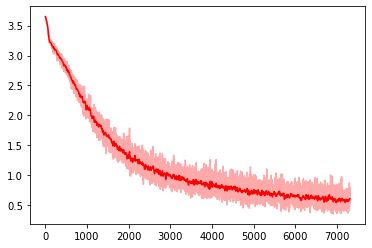

In [20]:
# Plot training loss
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [22]:
# Save trained model for later
torch.save(model.state_dict(), "attention.pt")

## Apply to unseen input

In [23]:
def translate(text):
    
    # Convert graphemes to indices
    input_sequences = text_vocabulary.encode(text).unsqueeze(1)
    input_lengths = torch.tensor([input_sequences.shape[0]], dtype=torch.long)
    
    # Encode
    memory_sequences = model.encoder(input_sequences, input_lengths)
    
    # Decode
    output_sequences, output_lengths = infer(
        model.decoder_cell,
        memory_sequences,
        input_lengths,
        max_output_per_input=3,
    )

    # Convert to phonemes
    pronunciation = pronunciation_vocabulary.decode(output_sequences[:, 0])
    return "".join(pronunciation)

In [33]:
translate("terrible")

'tɛʁibl'

In [29]:
translate("anticonstitutionnellement")

'ɑ̃tikɔ̃stityjɔ̃'

In [28]:
translate("un chat")

'ɛ̃n ʃa'

In [27]:
translate("l'arbre qui cache la forêt")

'laabbʁ kik al kaf ɔʁa'

In [24]:
translate("les poules du couvent couvent")

'lɛ pul dy kuvv'

## Show alignment

In [25]:
# TODO ...

## Evaluate on test set

In [26]:
# TODO ...